# Machine Learning II Data Challenge  
Time series analysis to predict house electricity consumption.

- Thomas de Mareuil
- Constantin Vodé
- Tommy Tran

## Introduction
### Challenge context

BCM Energy is a start-up based in Lyon and created in 2015. BCM operates on the whole value chain of renewable electricity, from production assets management on electricity markets (Epexspot, EEX) to electricity supply to final consumers through the brand Planète OUI:

BCM Energy is active continuously on the electricity markets,
BCM Energy is responsible of its own balancing perimeter,
BCM Energy also manages capacity certificates within its own certification perimeter and guarantees of origin in its register.
The diverse priority areas of growth are supported by a trading team with more than fifteen years of experience of the various electricity markets, developing state-of-the-art financial analysis modeling. Planète OUI, created in 2007, is one of the first French green electricity supplier. The company supplies tens of thousands of homes and professionals and covers more than 95 % of metropolitan France (Enedis network). Planète OUI promotes an ecology constructive and made available for all. It has integrated BCM Energy’s perimeter in 2017. The supplier has to offer green electricity supply with prices adapted to the consumption profiles of its clients. Indeed, the information of disaggregation consumption could help reduce electricity consumption and so reduce the electricity bill with customized advice or control of appliances of our clients (with their agreement).

### Challenge goals
The goal is to train an algorithm to replace many monitoring systems which are too intrusive and too expensive. This challenge is known as NILM (Nonintrusive load monitoring) or NIALM (Nonintrusive appliance load monitoring). The aim of the challenge is to find the part of electric consumption in one household dedicated to 4 appliances (washing machine, fridge_freezer, TV, kettle). There are no time constraints. The past and the future are known.

### Data description
The first line of the input contains the header, the columns are separated by ',', and decimals by decimal point. The columns are:

- the “time_step”: date measured each minute (format yyyy-MM-ddTHH :mm :ss.Z)
- the “consumption”: household consumption (W) measured each minute
- the “visibility”: distance at which it is possible to clearly distinguish an object (km) measured once per hour
- the “temperature”: temperature (°C) measured once per hour
- the “humidity”: presence of water in the air (%) measured once per hour
- the “humidex”: index used to integrate the combined effects of heat and humidity measured once per hour
- the “windchill”: an index that expresses the subjective feeling of cold or heat as a function of measured temperature, wind and humidity (°C) measured once per hour
- the “wind”: wind speed (km/h) measured once per hour
- the “pressure”: applied perpendicular to the surface of an object per unit area (Pa) measured once per hour


The first line of the output contains the header, the columns are separated by ',', and decimals by decimal point. The columns are:

- the “time_step”: date measured each minute (format yyyy-MM-ddTHH :mm :ss.Z)
- the “washing_machine”: washing machine power (W) measured each minute
- the “fridge_freezer”: fridge freezer power (W) measured each minute
- the “TV”: TV power (W) measured each minute
- the “kettle”: kettle power (W) measured each minute

- The train set contains 417 599 values with 10 231 missing values (2,44%) for “consumption”, “washing_machine”, “fridge_freezer”, “TV”, “kettle” and the test set contains 226 081 values with 24 719 missing values (10,93%).

## Data exploration

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.multioutput import MultiOutputRegressor
# https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression_multioutput.html

In [75]:
input_train = pd.read_csv('X_train.csv')
input_train = input_train.drop('Unnamed: 9', axis=1)
output_train = pd.read_csv('y_train.csv')

In [76]:
input_train.head()

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
output_train.head()

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


### Missing values

time_step      0.000000
consumption    0.024500
visibility     0.983391
temperature    0.983364
humidity       0.983391
humidex        0.983391
windchill      0.983410
wind           0.983391
pressure       0.983400
dtype: float64


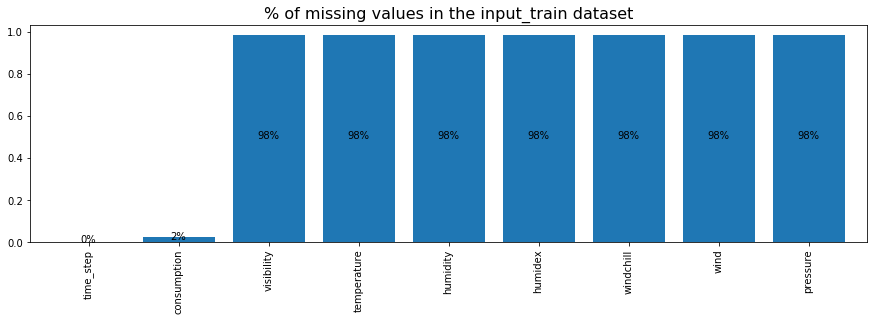

In [78]:
# Show % of missing values in the input_train dataset

missing = input_train.isna().sum()
missing = missing/len(input_train)
print(missing)


ax = missing.plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
plt.title("% of missing values in the input_train dataset",fontsize= 16)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.5*width, p.get_y()+.5*height), ha = 'center')

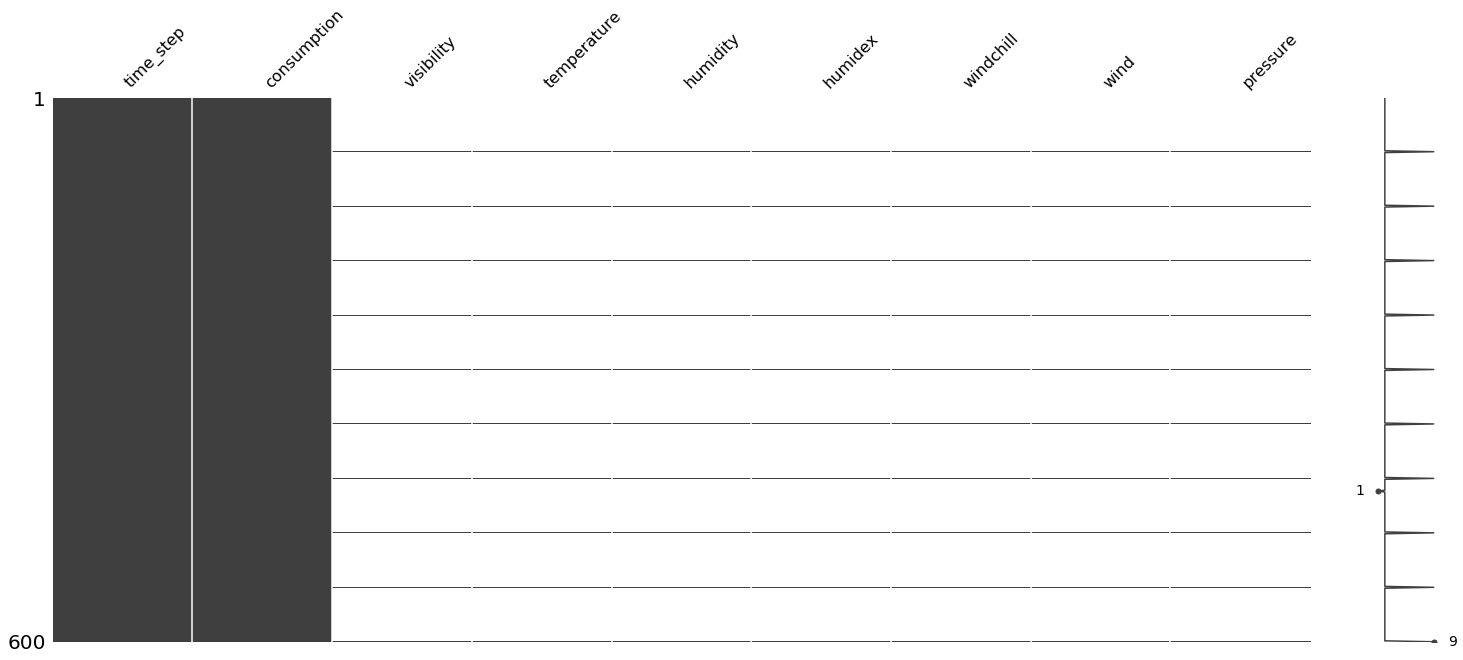

In [79]:
# Visualize missing values repartition in the first 10h of the dataset

import missingno as msno
msno.matrix(input_train[:600])

We can see that all meteorological features are measured once per hour (i.e. 10 values/lines are visible on the graph above, for the 10 first hours of the dataset), which explains the high proportion of missing values.

To impute these missing values in-between the measurements, we will use the [backward interpolation] method. (why?)

In [90]:
# Imputation of missing weather data with backward interpolation method

to_interpolate = input_train.columns[-7:] # selects weather features
inter = pd.Series.interpolate(input_train[to_interpolate], limit=60, limit_direction='backward')

inter[50:80]

,visibility,temperature,humidity,humidex,windchill,wind,pressure
50,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
51,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
52,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
53,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
54,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
55,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
56,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
57,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
58,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000
59,35.0,8.9,86.000000,8.9,6.000000,19.000000,1017.300000


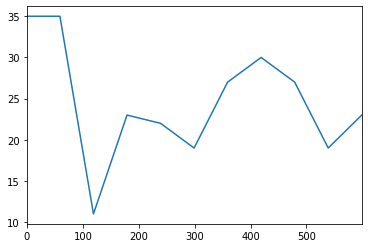

In [93]:
# Plot the imputed visibility feature in the first 10h

inter['visibility'][:600].plot()

We used a linear method to fill in the missing values between each hourly measurement.

### Time series transformation

In [81]:
# Convert the time_step feature into datetime in the input and output datasets

input_train['time_step'] = pd.to_datetime(input_train['time_step'])
output_train['time_step'] = pd.to_datetime(output_train['time_step'])

# Check data type
print(input_train['time_step'].dtype)
print(output_train['time_step'].dtype)

datetime64[ns]
datetime64[ns]


## Modeling

We want to predict, for each minute, the power used by the washing_machine, the fridge, the TV and the kettle. This is a multi-output regression.

### Baseline model: 4 univariate linear regressions

The benchmark is 4 univariate linear regressions (one per appliance). The inputs are consumption of the household, the day of the week (7 booleans), the weekend (1 boolean), and the circular hour of the day (sine and cosine).

### Our model: xxx

In [ ]:
#model = MultiOutputRegressor(estimator=)
#model.fit(input_train, output_train)

## Test metric

The metric we will use is (Wh) :
$$
\mathcal{L}(\widehat{y}, y) = \frac{1}{\sum_{j \: in \: appliances} \alpha_j} \sum_{j \: in \: appliances} \alpha_j \sqrt{\frac{\sum_{i=1}^{N} (\widehat{y}_{i}^{(j)}-y_{i}^{(j)})^2)}{N}}
$$

Where
* N = 201362 : number of data known in test set
* appliances = \{washing_machine, fridge_freezer, TV, kettle\}
* $\alpha_j = E(y_{i}^{(j)})$ : mean of power of the appliance j on training set
     * $\alpha_{washing\_machine} = 5.55$
     * $\alpha_{fridge_freezer} = 49.79$
     * $\alpha_{TV} = 14.57$
     * $\alpha_{kettle} = 4.95$

In [ ]:
import pandas as pd
import datetime as dt
import math as mt

def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

if __name__ == '__main__':
    import pandas as pd
    CSV_FILE_Y_TRUE = 'y_test.csv'
    CSV_FILE_Y_PRED = 'y_pred.csv'
    df_y_true = pd.read_csv(CSV_FILE_Y_TRUE, index_col=0, sep=',')
    df_y_pred = pd.read_csv(CSV_FILE_Y_PRED, index_col=0, sep=',')
    if df_y_true.shape[0] == df_y_pred.shape[0] :
        df_y_true = df_y_true.sort_values(by=['time_step'])
        df_y_pred = df_y_pred.sort_values(by=['time_step'])
        if (df_y_true.index[0]== df_y_pred.index[0]) & (df_y_true.index[df_y_true.shape[0]-1]== df_y_pred.index[df_y_pred.shape[0]-1]) :
            df_y_true['washing_machine'] = pd.to_numeric(df_y_true['washing_machine'], errors = 'nan')
            df_y_true['fridge_freezer'] = pd.to_numeric(df_y_true['fridge_freezer'], errors = 'nan')
            df_y_true['TV'] = pd.to_numeric(df_y_true['TV'], errors = 'nan')
            df_y_true['kettle'] = pd.to_numeric(df_y_true['kettle'], errors = 'nan')
            df_y_pred['washing_machine'] = pd.to_numeric(df_y_pred['washing_machine'], errors = 'nan')
            df_y_pred['fridge_freezer'] = pd.to_numeric(df_y_pred['fridge_freezer'], errors = 'nan')
            df_y_pred['TV'] = pd.to_numeric(df_y_pred['TV'], errors = 'nan')
            df_y_pred['kettle'] = pd.to_numeric(df_y_pred['kettle'], errors = 'nan')
            print(metric_nilm(df_y_true, df_y_pred))
        else :
            print('nan')
    else :
            print('nan')